# ECON-323 Final Project - Brazilian E-Commerce Dataset (Olist) Analysis
### Name: Ahnaf Tazwar Ayub
### Student #: 35562164

#### **Note** - Please visit the GitHub repository ([Link](https://github.com/tazwar22/econ323-project)) for the project for some basic setup information first (to make it easier to run the project).

## Sections
***

### 1. Introduction to Olist E-Commerce Dataset
### 2. Product Analysis: Order Segmentation & Freight Cost Prediction
### 3. Daily Sales Forecasting
### 4. Delivery Time Analysis
### 5. Conclusion/Future Extensions




***

# 1. Introduction to Olist E-Commerce Dataset
***

The domain of e-commerce offers massive potential for data mining and predictive modelling. Privacy concerns aside, having access to large amounts of anonymized sales data provides analysts with a rich store of information to learn from. Some key insights that may be gained from such data can recursively boost future sales, and in turn lead to even higher quality data in the future for later analysis. Courtesy of **Olist** and **Kaggle**, we have been provided access to such in-depth data on transactions from all over Brazil. 

The [**Brazillian E-commerce Dataset (by Olist)**](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) provides us with information on independent vendors and the products they sell, as well as the orders made my customers all over the country. With such information at hand, we may seek some **useful** and **novel** trends in the data, in order to streamline customer experience in the future, aid management in making decisions, and aid in enhancing the marketplace environment overall.

In this analysis, we will undertake the following tasks:
- Analyze popular products, delivery times and daily sales data
- Fit a predictive model capable of estimating freight costs associated with an order
- Build an unsupervised ML model capable of segmenting orders based on their prices and physical composition
- Fit and evaluate an Autoregressive forecasting model capable of predicting daily sales
- Train a predictive model capable of predicting delivery times based on order composition and seller-customer distance

## Imports/Data

Before we can get underway with our in-depth analysis, we must start off by importing the necessary libraries. We will be using a mix of different computational resources, aimed at assisting us with tasks related to visualization, prediction and so forth. 

Furthermore, to streamline the process of loading and working with the 9 separate datasets provided by Olist on Kaggle, we can define a function like **load(datasetName)** below.

In [1]:
#Imports
import os
import matplotlib.pyplot as plt
# %matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

#Data paths
datadir = os.path.join(os.getcwd(), 'archive')

# Simply maps each table name to the appropriate .csv file
data_map = {
    "customers" : os.path.join(datadir, 'olist_customers_dataset.csv'),
    "geolocation" : os.path.join(datadir, 'olist_geolocation_dataset.csv'),
    #Orders
    "order_items" : os.path.join(datadir, 'olist_order_items_dataset.csv'),
    "order_payments" : os.path.join(datadir, 'olist_order_payments_dataset.csv'),
    "order_reviews" : os.path.join(datadir, 'olist_order_reviews_dataset.csv'),
    # MAIN DATA
    "orders" : os.path.join(datadir, 'olist_orders_dataset.csv'),
    #Products
    "products" : os.path.join(datadir, 'olist_products_dataset.csv'),
    "sellers" : os.path.join(datadir, 'olist_sellers_dataset.csv'),
    "prod2cat_translation" : os.path.join(datadir, 'product_category_name_translation.csv')
}

def load(df_name):
    return pd.read_csv(data_map[df_name])

The **official schema** is atttached below for reference.

![Schema](OlistSchemaKaggle.png)

# 2. Product Analysis: Order Segmentation & Freight Cost Prediction
***

### Data

From the given data, we have access to a DataFrame that contains information on the products sold on the platform. It is worth noting that the category names are in Portuguese by default, so we can leverage the provided **translation** DataFrame to convert them to English.

In [2]:
products_df = load('products')
translate = load("prod2cat_translation")
print(f'Products: {products_df.shape}')
print(f'Translate: {translate.shape}')
products_df.head()

Products: (32951, 9)
Translate: (71, 2)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


The following DataFrame contains the translation from Portuguese to English, for each category.

In [3]:
translate.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


We merge with the original products DataFrame, to obtain a translation for each product automatically.

In [4]:
prod_translated = products_df.merge(translate, on='product_category_name')
print(prod_translated.shape)
prod_translated.head()

(32328, 10)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


### Product Category Mapper

We can quickly whip up a mapper that retrieves the product category of a given item (based on it's ID).

In [5]:
mapper = {}
for pid in prod_translated.index:
    row = prod_translated.loc[pid]
    mapper[row['product_id']] = row['product_category_name_english']

def get_catname(pid):
    if pid not in mapper:
        return 'unclassified'
    return mapper[pid]

## Physical Properties

Given the information we have (i.e. product weight, dimensions) can quite easily find out the categories with the heaviest and most dense products.  

In [6]:
prod_translated['product_volume_cm3'] = prod_translated['product_length_cm'] *prod_translated['product_height_cm']*prod_translated['product_width_cm']
prod_translated['product_volume_cm3']   

0          2240.0
1          2700.0
2          6048.0
3          3757.0
4          3510.0
           ...   
32323     15625.0
32324     18081.0
32325    262800.0
32326     70000.0
32327     13125.0
Name: product_volume_cm3, Length: 32328, dtype: float64

In [7]:
cat_gby = prod_translated.groupby('product_category_name_english') #Group-by category

most_vol = cat_gby['product_volume_cm3'].mean().sort_values(ascending=False).head(n=10) #Products with most volume
most_weight = cat_gby['product_weight_g'].mean().sort_values(ascending=False).head(n=10) #products with most weight

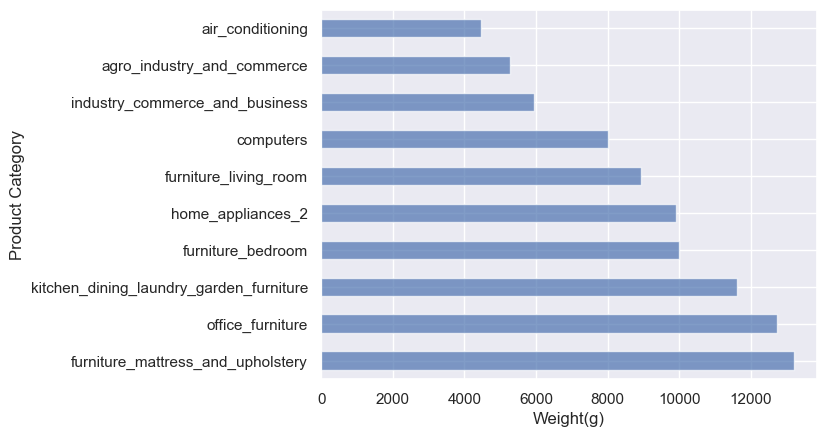

In [8]:
ax = most_weight.plot.barh(alpha=0.7)
ax.set_ylabel('Product Category')
ax.set_xlabel('Weight(g)')
plt.show()

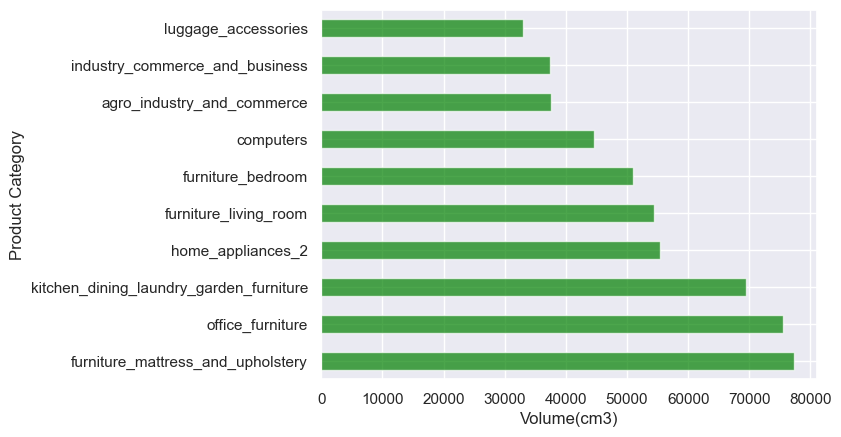

In [9]:
ax = most_vol.plot.barh(alpha=0.7, color='green')
ax.set_ylabel('Product Category')
ax.set_xlabel('Volume(cm3)')
plt.show()

It should be of little surprise that the products that are most dense, are also those which are heaviest.

Now, let's check across all available product categories, and determine which ones have the most/least instances of distinct products within them. (i.e. smallest/largest catalogues on the market)

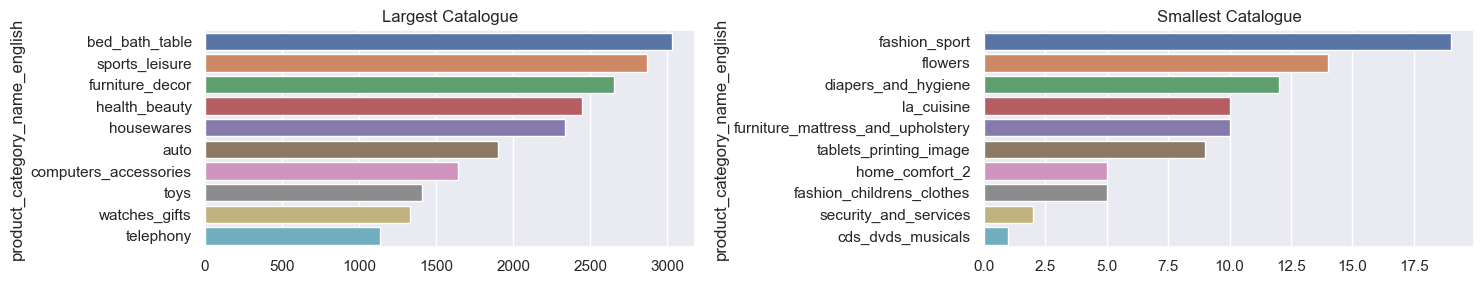

In [10]:
prod_counts = cat_gby['product_id'].count().sort_values(ascending=False)
fig, (a1, a2) = plt.subplots(1, 2, figsize=(15, 3))

#Find products with largest/smallest catalogues
largest_catalogue = prod_counts.head(n=10)
smallest_catalogue = prod_counts.tail(n=10)

sns.barplot(ax=a1, x=largest_catalogue.values, y=largest_catalogue.index)
sns.barplot(ax=a2, x=smallest_catalogue.values, y=smallest_catalogue.index)
a1.set_title('Largest Catalogue')
a2.set_title('Smallest Catalogue')
plt.tight_layout()
plt.show()

From the plots above, we can see:
1. Bed & Bath, Sports Leisure and Furnitures are the **most common** items (over 2500 varieties)
2. Children's clothes, musical disks (audio/video) and security items are the **least common** (with less than 5 instances)

## OrderItems

Let's load the DataFrame which contains the infornation on products sold **within each order**. We must **be careful** about multiple orders of the same item. 
From the data schema provided by Olist on Kaggle, we are told that **order_item_id** indicates the sequential number of items in the order.

In [11]:
orderitems_df = load('order_items')
orderitems_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
most_orders = orderitems_df.order_item_id.max()
most_items_id = orderitems_df.loc[orderitems_df.order_item_id == most_orders].order_id.values[0]
print(f'Order {most_items_id} with most items ({most_orders})')
print('*** Order summary ***')
orderitems_df[orderitems_df.order_id == most_items_id].groupby(['order_id', 'product_id']).size()

Order 8272b63d03f5f79c56e9e4120aec44ef with most items (21)
*** Order summary ***


order_id                          product_id                      
8272b63d03f5f79c56e9e4120aec44ef  05b515fdc76e888aada3c6d66c201dff    10
                                  270516a3f41dc035aa87d220228f844c    10
                                  79ce45dbc2ea29b22b5a261bbb7b7ee7     1
dtype: int64

In the order with the most items, the customer ordered 21 units overall, with 10 units each of 2 products and just 1 unit of a third item.

We **join** with the products table, in order to find stats regarding product prices and associated freight costs.

In [13]:
ord2prod = orderitems_df.merge(prod_translated, on='product_id')
ord2prod.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0


Note that we can have the same order containing **1,2,...k** instances of the item **product_id**. 

In [14]:
print(ord2prod[['order_id', 'product_id']].duplicated().any())
print(ord2prod[['order_id', 'product_id', 'order_item_id']].duplicated().any())

True
False


As given on the Kaggle repository, we can check what a test instance where **3 units** of item **e95ee6822b66ac6058e2e4aff656071a** were ordered.

In this case, the total cost payable by the customer who placed the order, is:

$$
3*(\text{price of item} + \text{freight_value of item})
$$

In [15]:
# Test case
ord2prod.groupby(['order_id', 'product_id']).get_group(('00143d0f86d6fbd9f9b38ab440ac16f5', 'e95ee6822b66ac6058e2e4aff656071a'))

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
1315,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0
1316,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0
1317,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0


## Product Expenditure Analysis

In [16]:
#Contains the information regarding each order/item pair
ord_stats = ord2prod.groupby(['order_id', 'product_id'])[[ 'product_weight_g', 'product_volume_cm3', 'price', 'freight_value',]].sum()
print(ord_stats.index.duplicated().any())
if ord_stats.duplicated().any():
    ord_stats = ord_stats.drop_duplicates()
ord_stats

False


,,product_weight_g,product_volume_cm3,price,freight_value
order_id,product_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,650.0,3528.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,30000.0,60000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,3050.0,14157.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,200.0,2400.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,3750.0,42000.0,199.90,18.14
...,...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,ebceb9726cf5c6187b48e17fe58747b0,200.0,2250.0,17.90,22.06
fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,1400.0,9856.0,220.00,136.76
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,10150.0,53400.0,299.99,43.41


We reset the product id's back to a column. We also, leverage the **mapper** from earlier.

In [17]:
ord_stats.reset_index('product_id', inplace=True)
ord_stats

,product_id,product_weight_g,product_volume_cm3,price,freight_value
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,650.0,3528.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,30000.0,60000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,3050.0,14157.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,200.0,2400.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,3750.0,42000.0,199.90,18.14
...,...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,ebceb9726cf5c6187b48e17fe58747b0,200.0,2250.0,17.90,22.06
fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,1400.0,9856.0,220.00,136.76
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,10150.0,53400.0,299.99,43.41


In [18]:
ord_stats['product_category'] = ord_stats.product_id.apply(get_catname)

By leveraging **GROUP-BY** on the order id's (to get each row as a unique order), we can aggregate the costs and weights from products within the order.

In [19]:
order_totals = ord_stats.groupby('order_id').sum()
assert not order_totals.index.duplicated().any()
order_totals

,product_weight_g,product_volume_cm3,price,freight_value
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,650.0,3528.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,30000.0,60000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,3050.0,14157.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,200.0,2400.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,42000.0,199.90,18.14
...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,200.0,2250.0,17.90,22.06
fffb9224b6fc7c43ebb0904318b10b5f,1400.0,9856.0,220.00,136.76
fffc94f6ce00a00581880bf54a75a037,10150.0,53400.0,299.99,43.41


Also, by grouping by the **categories**, we can analyze the performance of each.


In [20]:
ord_stats.groupby('product_category').count()

,product_id,product_weight_g,product_volume_cm3,price,freight_value
product_category,,,,,
agro_industry_and_commerce,168,168,168,168,168
air_conditioning,223,223,223,223,223
art,135,135,135,135,135
arts_and_craftmanship,22,22,22,22,22
audio,214,214,214,214,214
...,...,...,...,...,...
stationery,1859,1859,1859,1859,1859
tablets_printing_image,56,56,56,56,56
telephony,2828,2828,2828,2828,2828


In [21]:
ord_stats.groupby('product_category').mean()

,product_weight_g,product_volume_cm3,price,freight_value
product_category,,,,
agro_industry_and_commerce,4373.505952,27495.869048,411.746905,33.183810
air_conditioning,5047.820628,30510.282511,230.249596,27.805247
art,1645.014815,13771.496296,132.194148,21.720667
arts_and_craftmanship,1353.500000,8464.681818,74.437273,15.765455
audio,1130.565421,4265.799065,143.510140,17.775748
...,...,...,...,...
stationery,2538.265734,20726.004303,99.182109,20.201872
tablets_printing_image,338.267857,6615.357143,103.325536,16.828393
telephony,272.258133,2019.491867,86.595071,17.547588


Let's combine all the available information on categories.


In [22]:
#Each row is a product category; features include the total money spent on these products
product_cats = ord_stats.groupby('product_category').mean()
product_cats['num_orders'] = ord_stats.groupby('product_category').price.count()
product_cats

,product_weight_g,product_volume_cm3,price,freight_value,num_orders
product_category,,,,,
agro_industry_and_commerce,4373.505952,27495.869048,411.746905,33.183810,168
air_conditioning,5047.820628,30510.282511,230.249596,27.805247,223
art,1645.014815,13771.496296,132.194148,21.720667,135
arts_and_craftmanship,1353.500000,8464.681818,74.437273,15.765455,22
audio,1130.565421,4265.799065,143.510140,17.775748,214
...,...,...,...,...,...
stationery,2538.265734,20726.004303,99.182109,20.201872,1859
tablets_printing_image,338.267857,6615.357143,103.325536,16.828393,56
telephony,272.258133,2019.491867,86.595071,17.547588,2828


## Identifying high-value order groups (Unsupervised Learning)

Given information on the revenue earned from various orders, as well as the amount of products sold within each, we can leverage an Unsupervised ML method (such as K-Means clustering) in order to segment the orders into distinct groups with similar features. New, unseen orders can be classified as one of these clusters in the future, and aid in classifying them as being of a specific intrinsic value.

Fitting such an Unsupervised model is a simple process thanks to sklearn, however, we must remember to normalize the input features since this method is highly sensitive to distances.

**Note: Much of the underlying theory behind K-Means that I have applied here are from the intuition I have developed from past internship experiences and lectures (CPSC-340). I have also referred to [this article](https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c) as a quick refresher.**

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

X = order_totals[['product_weight_g', 'product_volume_cm3', 'price', 'freight_value']].values
print(X.shape)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

(69902, 4)


A common method to determine the optimal value for the hyper-parameter **k** is to detect the **elbow** on the distortion (within-cluster SSE) v.s. number of clusters plot (as shown below).

100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


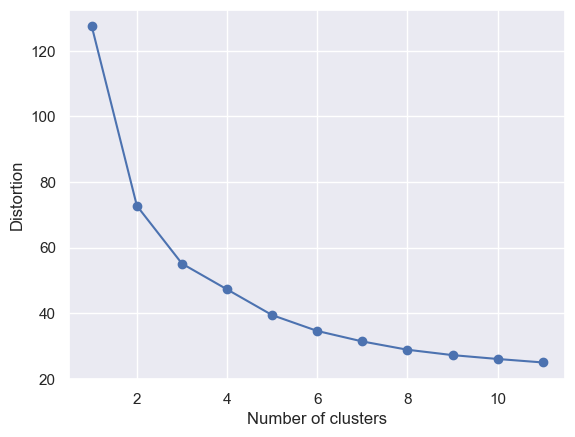

In [24]:
'''
Elbow method to determine optimal number of clusters
References - 
    1. Code - https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
    2. Intuition - UBC CPSC-340 : Machine Learning & Data Mining Notes - https://www.cs.ubc.ca/~fwood/CS340/
'''
from tqdm import tqdm 

distortions = []
k_vals = [k for k in range(1, 12)]
for k in tqdm(k_vals):
    #Fit
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(k_vals, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

We can clearly see the gradient flattening out beyond **k=8**, so we opt for this as our desired number of clusters.

In [25]:
km = KMeans(n_clusters=8)
km.fit(X)
y_km = km.predict(X)
order_totals['cluster'] = y_km
order_totals

,product_weight_g,product_volume_cm3,price,freight_value,cluster
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,650.0,3528.0,58.90,13.29,1
00018f77f2f0320c557190d7a144bdd3,30000.0,60000.0,239.90,19.93,2
000229ec398224ef6ca0657da4fc703e,3050.0,14157.0,199.00,17.87,0
00024acbcdf0a6daa1e931b038114c75,200.0,2400.0,12.99,12.79,1
00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,42000.0,199.90,18.14,0
...,...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,200.0,2250.0,17.90,22.06,1
fffb9224b6fc7c43ebb0904318b10b5f,1400.0,9856.0,220.00,136.76,0
fffc94f6ce00a00581880bf54a75a037,10150.0,53400.0,299.99,43.41,5


Now that we have assigned each order to a cluster, we can analyze the stats within each group, and distinguish between them to identify high-value clusters.

We must start by checking the distribution of observations within the clusters however. (We use **log-10** transformation to actually see some of the less-dense clusters in contrast with the more dense).

[4.09739615 4.67259655 3.27253778 1.79934055 2.68033551 3.72304499
 3.37032801 2.45939249]


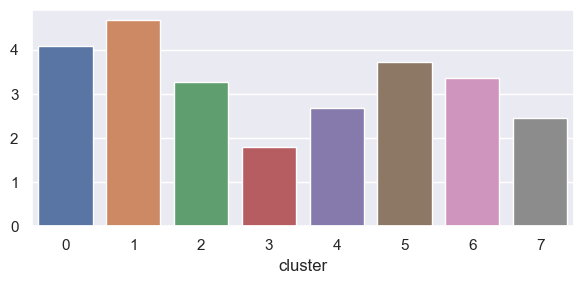

In [26]:
cluster_densities = np.log10(order_totals.groupby('cluster').size().values)
print(cluster_densities)
clusters = order_totals.groupby('cluster').size().index
fig, a1 = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(ax=a1, x=clusters, y=cluster_densities)
a1.set_title('')
plt.tight_layout()
plt.show()

We can find all of the orders that belong to a particular cluster as follows:

In [27]:
order_totals.loc[order_totals.cluster == 2]

,product_weight_g,product_volume_cm3,price,freight_value,cluster
order_id,,,,,
00018f77f2f0320c557190d7a144bdd3,30000.0,60000.0,239.90,19.93,2
000576fe39319847cbb9d288c5617fa6,13805.0,118125.0,810.00,70.75,2
0030ff924c38549807645976adeef2c0,23250.0,96600.0,225.00,67.24,2
0078a358a14592b887eb140ef515f5ab,19200.0,116000.0,253.52,82.86,2
00ab9fa91aafa3d881164b0da48999aa,16550.0,96000.0,579.00,65.34,2
...,...,...,...,...,...
fee5a1127dde04aca98c3dd84e96d471,16600.0,97308.0,239.98,37.10,2
feebdd36c3e19b95f31008e3e62dc32e,19650.0,125400.0,139.99,60.89,2
ff36f4d6d98c0b2a7e70acb7d1b3f139,16900.0,88985.0,109.00,57.30,2


In [28]:
clusters

Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64', name='cluster')

In [29]:
cluster_gby = order_totals.groupby('cluster').mean()
cluster_gby

,product_weight_g,product_volume_cm3,price,freight_value
cluster,,,,
0,3210.191865,28655.010708,154.219771,28.820316
1,659.136864,6497.910465,87.558432,17.836420
2,18582.699413,103987.023492,379.322098,69.924650
3,74781.476190,504992.698413,948.267460,300.389683
4,32938.841336,211201.127349,662.754071,135.874781
5,9494.467550,56452.864711,213.358689,40.882727
6,1919.633419,13920.714408,728.355584,33.177421
7,8143.243056,45253.774306,2301.744132,77.099479


We can visualize the distributions of the **monetary value** of each cluster, as well as the **weight** of products that it is composed of.

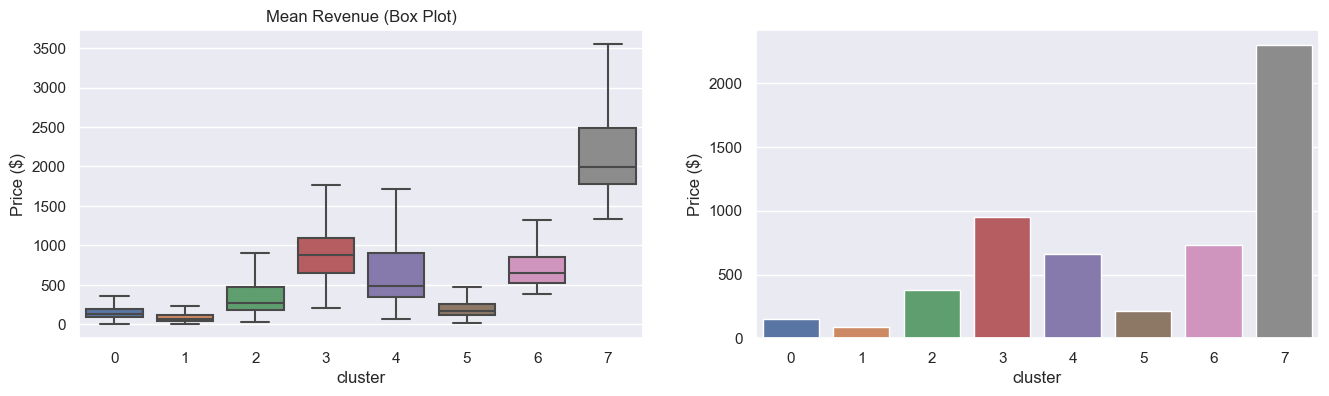

In [30]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(16,4))
factor = "price"
sns.boxplot(x="cluster", y=factor, data=order_totals, ax=a1, showfliers = False)
sns.barplot(x=clusters, y=cluster_gby[factor].values , ax=a2)
a1.set_title('Mean Revenue (Box Plot)')
a1.set_ylabel('Price ($)')
a2.set_ylabel('Price ($)')
plt.show()

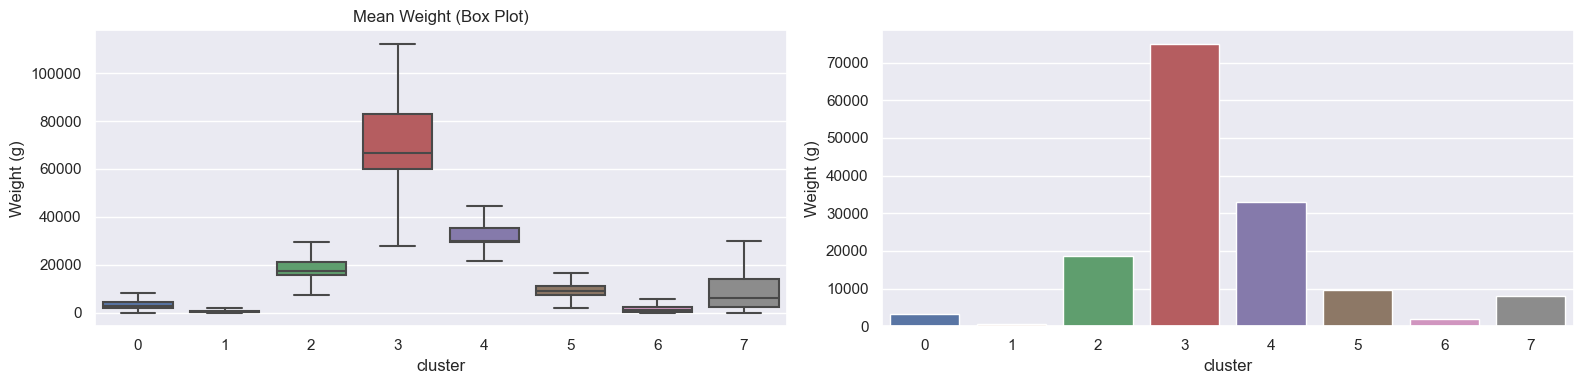

In [31]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(16,4))
factor = "product_weight_g"
sns.boxplot(x="cluster", y=factor, data=order_totals, ax=a1, showfliers = False)
sns.barplot(x=clusters, y=cluster_gby[factor].values , ax=a2)
a1.set_title('Mean Weight (Box Plot)')
a1.set_ylabel('Weight (g)')
a2.set_ylabel('Weight (g)')
plt.tight_layout()
plt.show()

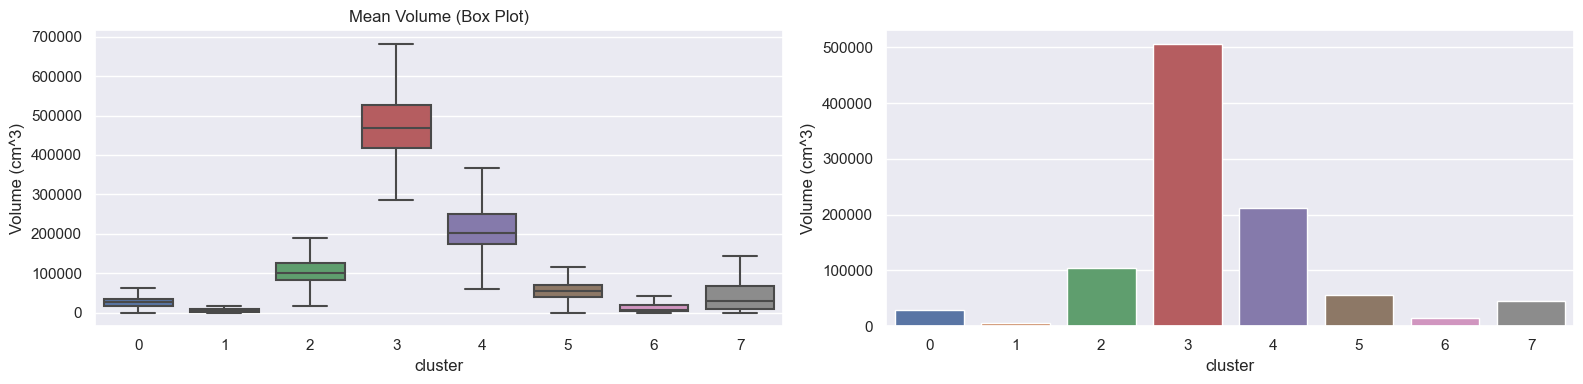

In [32]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(16,4))
factor = "product_volume_cm3"
sns.boxplot(x="cluster", y=factor, data=order_totals, ax=a1, showfliers = False)
sns.barplot(x=clusters, y=cluster_gby[factor].values , ax=a2)
a1.set_title('Mean Volume (Box Plot)')
a1.set_ylabel('Volume (cm^3)')
a2.set_ylabel('Volume (cm^3)')
plt.tight_layout()
plt.show()

In [33]:
most_expensive = list(clusters[np.argsort(cluster_gby['price'].values)[::-1][:3]])
heaviest = clusters[np.argmax(cluster_gby['product_weight_g'].values)]
most_dense = clusters[np.argmax(cluster_gby['product_volume_cm3'].values)]
assert heaviest == most_dense #logically
print(f'Cluster with most expensive orders: {most_expensive}')
print(f'Cluster with heaviest item orders: {heaviest}')
print(f'Cluster with most dense item orders: {most_dense}')

Cluster with most expensive orders: [7, 3, 6]
Cluster with heaviest item orders: 3
Cluster with most dense item orders: 3


Let's test out a new order which contains **heavier** items.

In [34]:
test_point = pd.DataFrame([[55e3, 400e3, 800, 700]], columns=['product_weight_g','product_volume_cm3','price','freight_value'])
print(test_point)
pred_cluster = km.predict(scaler.transform(test_point.values))[0]
print(f'Order predicted to be in cluster: {pred_cluster}')

   product_weight_g  product_volume_cm3  price  freight_value
0           55000.0            400000.0    800            700
Order predicted to be in cluster: 3


### Analyzing Orders

Now that we have stats regarding the contents (from the products within) an order, we can perform some in-depth analysis on them. We aim to inspect:
1. Distributions of all orders
2. Performance of items categories (individual / multiple)
3. Impact of item size/dimensions on revenue
4. Freight Cost Analysis

#### Analyzing all orders

Given the total weight, volume and cost of items within each order, we can analyze their distributions.

In [35]:
order_totals

,product_weight_g,product_volume_cm3,price,freight_value,cluster
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,650.0,3528.0,58.90,13.29,1
00018f77f2f0320c557190d7a144bdd3,30000.0,60000.0,239.90,19.93,2
000229ec398224ef6ca0657da4fc703e,3050.0,14157.0,199.00,17.87,0
00024acbcdf0a6daa1e931b038114c75,200.0,2400.0,12.99,12.79,1
00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,42000.0,199.90,18.14,0
...,...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,200.0,2250.0,17.90,22.06,1
fffb9224b6fc7c43ebb0904318b10b5f,1400.0,9856.0,220.00,136.76,0
fffc94f6ce00a00581880bf54a75a037,10150.0,53400.0,299.99,43.41,5


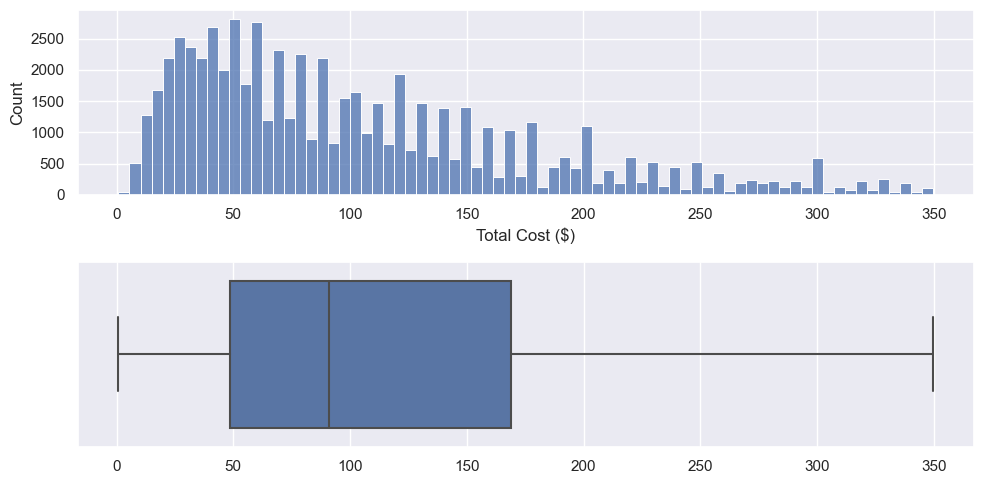

In [36]:
fig, (a1, a2) = plt.subplots(2, 1, figsize=(10,5))
prices = order_totals.price.values
sns.histplot(prices[np.where(prices < np.percentile(prices, 92))], ax=a1) #Plot subset, to avoid outliers
a1.set_xlabel('Total Cost ($)')
sns.boxplot(x = prices, showfliers = False, ax= a2)
plt.tight_layout()
plt.show()

From the plots above, we can clearly see:
1. There are several large outliers present (since we avoid plotting them altogether, one may easily see the plots with them as well)
2. The distribution of total (item) costs (excluding freight costs) is right-skewed, with median ~$91.0 total for an order

### Freight Cost Predictor

Let's visualize how the physical attributes of the items within the orders factor into the freight cost paid. Intuitively, orders with heavier items should have higher freight cost.

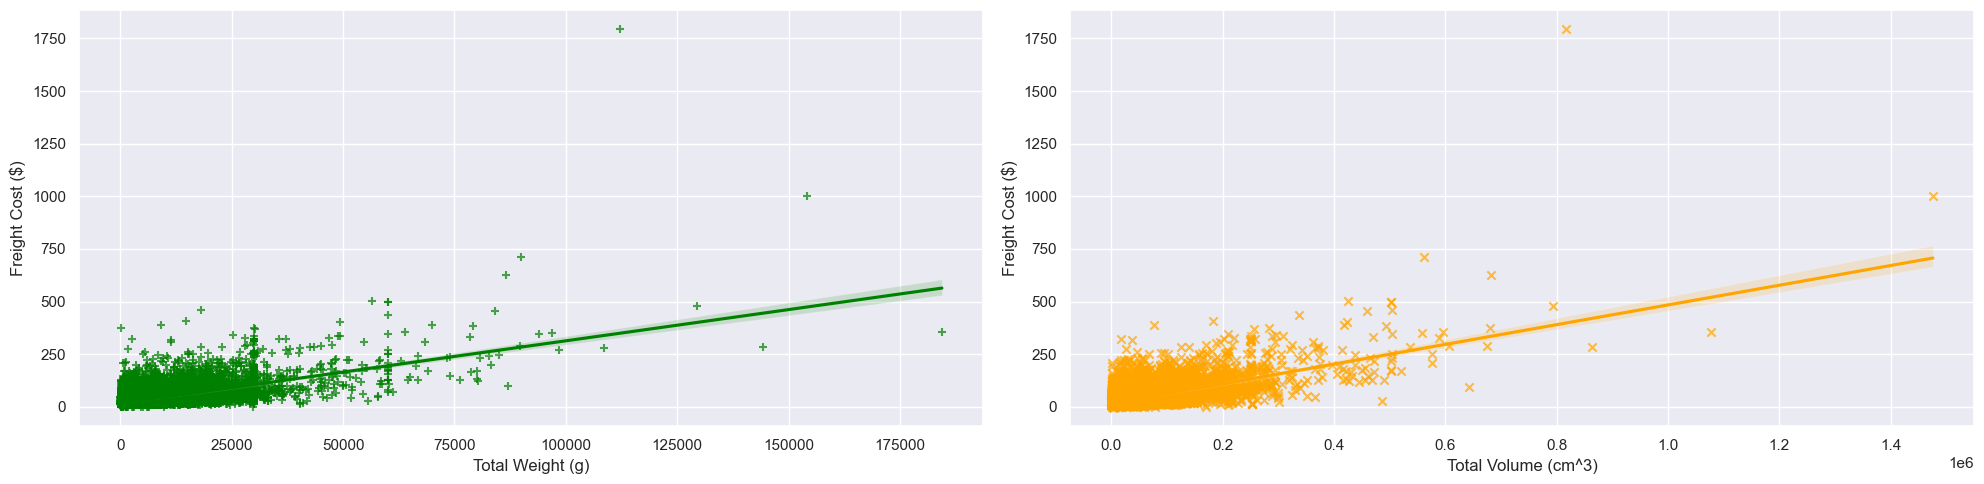

In [37]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(20, 5))
do_subset = False
#Subset
freight_values = order_totals.freight_value.values
volumes = order_totals.product_volume_cm3.values
weights = order_totals.product_weight_g.values
#Optionally subset
if do_subset:
    idx = np.where(volumes < np.percentile(volumes, 75))
    freight_values = freight_values[idx]
    volumes = volumes[idx]
    weights = weights[idx]

sns.regplot(ax=a1, x=weights, y=freight_values, color='green', marker='+', scatter_kws={'alpha':0.7})
sns.regplot(ax=a2, x=volumes, y=freight_values, color='orange', marker='x', scatter_kws={'alpha':0.7})
a1.set_ylabel('Freight Cost ($)')
a2.set_ylabel('Freight Cost ($)')
a1.set_xlabel('Total Weight (g)')
a2.set_xlabel('Total Volume (cm^3)')
plt.tight_layout()
plt.show()

Clearly, we can see that heavier/denser products have higher freight costs associated with them. This serves as the motivation to fit a regression model to predict the freight costs based on the physical product composition of an order.

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

data = order_totals[['product_weight_g', 'product_volume_cm3', 'freight_value']]

X = data[['product_weight_g', 'product_volume_cm3']].values
y = data['freight_value'].values
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'X_train shape: {X_train.shape} \t X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}')

X shape: (69902, 2)
y shape: (69902,)
X_train shape: (66406, 2) 	 X_test shape: (3496, 2)
y_train shape: (66406,) 	 y_test shape: (3496,)


In the following code block, we fit a **RandomForest** Regressor with some basic hyperparameters (**15 base trees, max depth of 5 per tree**).

In [39]:
model = RandomForestRegressor(n_estimators = 15 , max_depth=5, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

#Errors
errors = {}
errors['train_rmse'] = np.sqrt(mean_squared_error(y_train, yhat_train))
errors['test_rmse'] = np.sqrt(mean_squared_error(y_test, yhat_test))
errors['train_mae'] = mean_absolute_error(y_train, yhat_train)
errors['test_mae'] = mean_absolute_error(y_test, yhat_test)
errors['train_r2'] = r2_score(y_train, yhat_train)
errors['test_r2'] = r2_score(y_test, yhat_test)

errors

{'train_rmse': 16.716302528512518,
 'test_rmse': 15.462128831335544,
 'train_mae': 9.540964384642464,
 'test_mae': 9.34371642975447,
 'train_r2': 0.5303904887388842,
 'test_r2': 0.45202119575878785}

The model performs quite well, achieving an **R2 score** of **45%**, indicating it can explain quite a decent portion of the variance in the data.

We can test out our trained model to predict the freight cost based on the products within an order. Such information can be used in various ways:
1. Displayed to the user at checkout
2. Used to improve delivery routes

In [40]:
test_point = {'product_weight_g':700.0, 'product_volume_cm3':3600.0}
round(model.predict([[test_point['product_weight_g'], test_point['product_volume_cm3']]])[0], 2)

19.91

# 3. Daily Sales Forecasting
***

The aim of this section is to analyze **daily sales** on the platform, and leverage a forecasting model to predict future sales.

In [41]:
orders_main = load('orders')
orders_main.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Recall, we have the DataFrame which contains information on each order, and the products within it.

In [42]:
ord2prod

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111018,ffebd80e3291e811c308365936897efd,1,4cc4d02efc8f249c13355147fb44e34d,d1c7fa84e48cfa21a0e595167c1c500e,2018-07-18 20:23:55,129.9,51.20,ferramentas_jardim,37.0,653.0,1.0,6700.0,35.0,12.0,22.0,garden_tools,9240.0
111019,ffee31fb4b5e35c9123608015637c495,1,b10ecf8e33aaaea419a9fa860ea80fb5,0241d4d5d36f10f80c644447315af0bd,2018-08-21 10:10:11,99.0,13.52,moveis_decoracao,30.0,308.0,1.0,2300.0,37.0,30.0,20.0,furniture_decor,22200.0
111020,fff7c4452f050315db1b3f24d9df5fcd,1,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,2017-06-07 17:05:23,736.0,20.91,relogios_presentes,33.0,658.0,3.0,400.0,19.0,9.0,15.0,watches_gifts,2565.0
111021,fffa82886406ccf10c7b4e35c4ff2788,1,bbe7651fef80287a816ead73f065fc4b,8f2ce03f928b567e3d56181ae20ae952,2017-12-22 17:31:42,229.9,44.02,esporte_lazer,32.0,280.0,2.0,2700.0,60.0,15.0,15.0,sports_leisure,13500.0


We can merge this DataFrame with the one which contains all sorts of detailed information on each order (particularly, timestamps regarding when the order was placed, when the items were handed off to the logistics partner, and eventually delivered to the customer).

In [43]:
#Contains all the available information (order times, product info)
orders_full = ord2prod.merge(orders_main, on = 'order_id')
orders_full.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_width_cm,product_category_name_english,product_volume_cm3,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00


We can now simply formulate the time series version of the sales data, i.e. downsample the order purchase timestamps to daily data by summing across all the orders within a day.

In [44]:
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full.order_purchase_timestamp)
df_ts = orders_full.set_index('order_purchase_timestamp').sort_index()
df_ts

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.0,754.0,...,6.0,28.0,furniture_decor,5376.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.0,426.0,...,6.0,28.0,furniture_decor,5376.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
2016-09-05 00:15:34,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,telefonia,42.0,381.0,...,2.0,25.0,telephony,1250.0,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-10-07 13:17:15,NaN,NaN,2016-10-28 00:00:00
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,...,16.0,16.0,health_beauty,4096.0,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,...,16.0,16.0,health_beauty,4096.0,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-29 14:18:23,0b223d92c27432930dfe407c6aea3041,1,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,moveis_cozinha_area_de_servico_jantar_e_jardim,44.0,112.0,...,49.0,49.0,kitchen_dining_laundry_garden_furniture,115248.0,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04 00:00:00
2018-08-29 14:18:28,168626408cb32af0ffaf76711caae1dc,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-08-31 14:30:23,45.90,15.39,beleza_saude,26.0,394.0,...,16.0,28.0,health_beauty,13888.0,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11 00:00:00
2018-08-29 14:52:00,03ef5dedbe7492bdae72eec50764c43f,1,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,2018-08-31 15:05:22,24.90,8.33,artigos_de_festas,54.0,429.0,...,9.0,19.0,party_supplies,4788.0,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03 00:00:00


Let's look at the daily sales data (excluding freight cost) across the available timeframe.

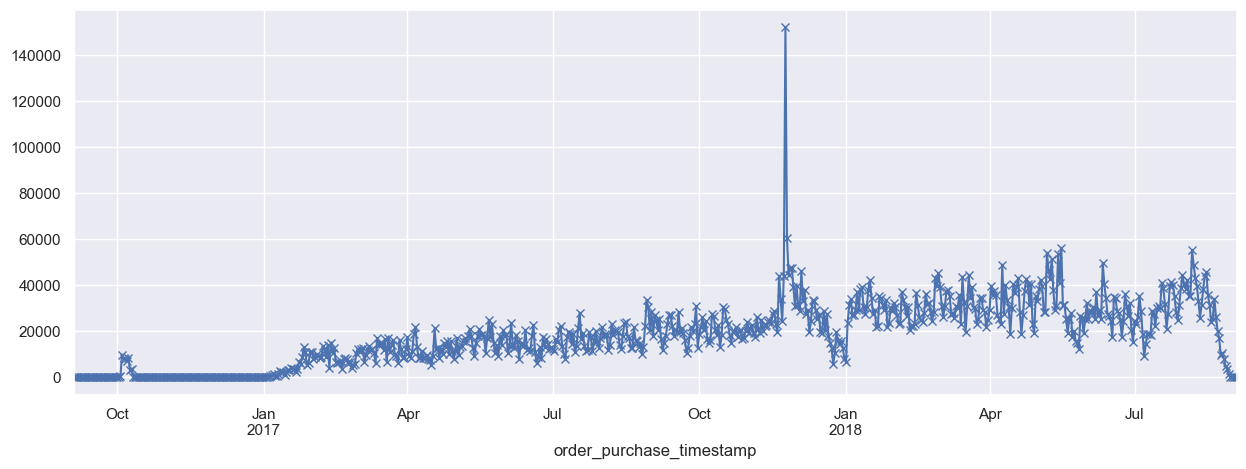

In [45]:
df_ts.resample('1d').sum()['price'].plot(figsize=(15,5), marker='x')
plt.show()

We have some unusual activity during 2016. Let's dive into it.

In [46]:
df_16 = df_ts.loc['2016']
# print(df_16)
# df_16.loc[df_16.price > 0].shape
df_16 = df_16.resample('1d').sum()
df_16 = df_16.loc[df_16.price > 0]
df_16.shape

(13, 11)

We **only have 13 non-zero observations** within 2016. Let's skip the year entirely.

In [47]:
print(f'Original shape: {df_ts.shape}')
df_ts = df_ts.loc[df_ts.index >= '2017']
print(f'New shape: {df_ts.shape}')

Original shape: (111023, 23)
New shape: (110655, 23)


We can also see the tail near the end of **2018** with all 0 values (i.e. no transactions near the end of August and beginning of September)

In [48]:
df_ts.loc['2018'].resample('1d').sum().tail(n=10)

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
order_purchase_timestamp,,,,,,,,,,,
2018-08-25,81,10599.41,1138.35,3675.0,57516.0,167.0,126282.0,2109.0,1080.0,1609.0,872790.0
2018-08-26,91,8010.81,1254.77,4097.0,69656.0,199.0,124425.0,2155.0,1114.0,1729.0,821553.0
2018-08-27,76,4798.12,730.52,3381.0,55349.0,162.0,76427.0,1963.0,1075.0,1459.0,729637.0
2018-08-28,54,3673.91,447.31,2236.0,40846.0,92.0,65353.0,1152.0,607.0,1042.0,557697.0
2018-08-29,27,1546.04,216.66,716.0,15297.0,28.0,34184.0,414.0,236.0,342.0,295701.0
2018-08-30,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-31,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-01,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-02,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will cut off the tail of the 2018 data beyond 29th August, to avoid dealing with any potential real-life issues that may have impacted the Olist sales during those days.

In [49]:
df_ts = df_ts.loc[df_ts.index < '2018-08-29']
df_ts

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-05 11:56:06,ec7a019261fce44180373d45b442d78f,1,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.90,8.72,fashion_bolsas_e_acessorios,64.0,1710.0,...,2.0,11.0,fashion_bags_accessories,352.0,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01 00:00:00
2017-01-05 12:01:20,b95a0a8bd30aece4e94e81f0591249d8,1,6c04a068e5ab37749c980c42a036b9e3,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:01:20,10.90,8.72,automotivo,52.0,1367.0,...,2.0,11.0,auto,352.0,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13 00:00:00
2017-01-05 12:06:36,38bcb524e1c38c2c1b60600a80fc8999,1,680cc8535be7cc69544238c1d6a83fe8,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:06:36,2.90,8.72,pet_shop,48.0,1392.0,...,2.0,11.0,pet_shop,352.0,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13 00:00:00
2017-01-05 12:09:08,7a18a504c1a4b32d883e68de2e1a7db0,1,c0d4027067afcf9c1697cce981b8fed6,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:09:08,7.90,8.72,pet_shop,63.0,1269.0,...,2.0,11.0,pet_shop,352.0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-07 03:44:08,2017-01-11 15:35:53,2017-01-16 15:43:29,2017-02-13 00:00:00
2017-01-05 12:11:23,6acecf438369055d9243e121045cca74,1,1514ddb0f4a5afc8d24104e89c714403,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:11:23,9.90,8.72,pet_shop,54.0,282.0,...,2.0,11.0,pet_shop,352.0,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-28 21:56:12,3064071cf67a2cc381cd53b13055eac5,1,15de022edf1005363381e66bed514528,537eb890efff034a88679788b647c564,2018-08-31 08:30:21,19.90,7.56,moveis_decoracao,52.0,361.0,...,3.0,23.0,furniture_decor,1104.0,931bfab7036f6763dc1bdf6e2696e08b,delivered,2018-08-29 08:30:21,2018-08-29 13:53:00,2018-08-30 19:04:08,2018-09-03 00:00:00
2018-08-28 21:56:30,dbb786f88b6d4e52fe3cb5d771b979d6,1,39a1a3b9314738724fce4b2907ae6686,da8622b14eb17ae2831f4ac5b9dab84a,2018-09-04 22:10:12,149.90,12.07,cama_mesa_banho,60.0,198.0,...,7.0,32.0,bed_bath_table,7616.0,478778636c75019554439f75286a22e3,delivered,2018-08-28 22:10:12,2018-08-29 19:02:00,2018-08-30 18:22:45,2018-09-05 00:00:00
2018-08-28 22:30:32,e7c290bfc31d7eed478c3d3d2d4d2953,2,44406b87e5ac6494cdb0c9dccd3b88d3,7dc8c42cc750eeafea6c85712ffee9bf,2018-09-11 22:43:50,39.99,9.03,construcao_ferramentas_jardim,57.0,217.0,...,25.0,25.0,costruction_tools_garden,15625.0,004440537b68545ca3c341d7279bc4c0,delivered,2018-08-28 22:43:50,2018-08-29 15:00:00,2018-08-30 17:18:48,2018-09-12 00:00:00


Let's look at the **querterly sales figures**.

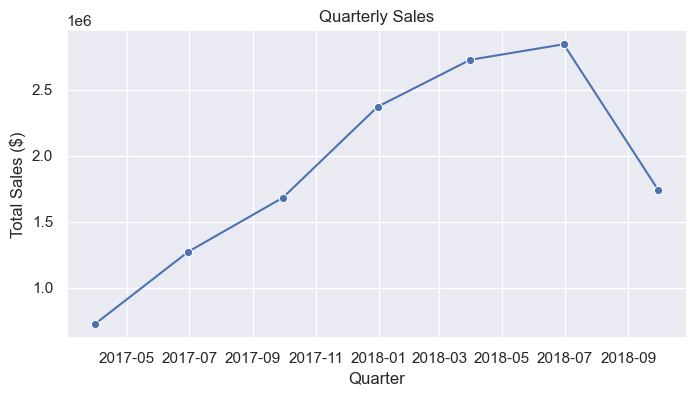

In [50]:
quart = df_ts.resample('Q').sum()['price']
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x=quart.index, y=quart.values, marker='o')
ax.set_xlabel('Quarter')
ax.set_ylabel('Total Sales ($)')
ax.set_title('Quarterly Sales')
plt.show()

Now, let us formulate and analyze the daily total sales data.

In [51]:
series = df_ts.resample('1d')['price'].sum()
series

order_purchase_timestamp
2017-01-05      396.90
2017-01-06      916.38
2017-01-07     1351.90
2017-01-08      709.58
2017-01-09      673.79
                ...   
2018-08-24     9633.61
2018-08-25    10599.41
2018-08-26     8010.81
2018-08-27     4798.12
2018-08-28     3673.91
Freq: D, Name: price, Length: 601, dtype: float64

**Note**: much of the underlying theory applied in this forecasting section is from the knowledge I've gained from the UBC course **STAT-443: Time Series & Forecasting ([See Link](https://courses.students.ubc.ca/cs/courseschedule?pname=subjarea&tname=subj-course&dept=STAT&course=443))**.

Let's plot the **daily sales** data, as well as the Autocorrelation and Partial Autocorrelation. 

From the **ACF** plot, a gradually decaying pattern indicates that an **[Autoregressive](https://en.wikipedia.org/wiki/Autoregressive_model)** model may be suitable to model the underlying time series. From the corresponding **PACF** plot, a sharp cut-off at **lag-k** indicates that an **AR(k)** model may be appropriate.

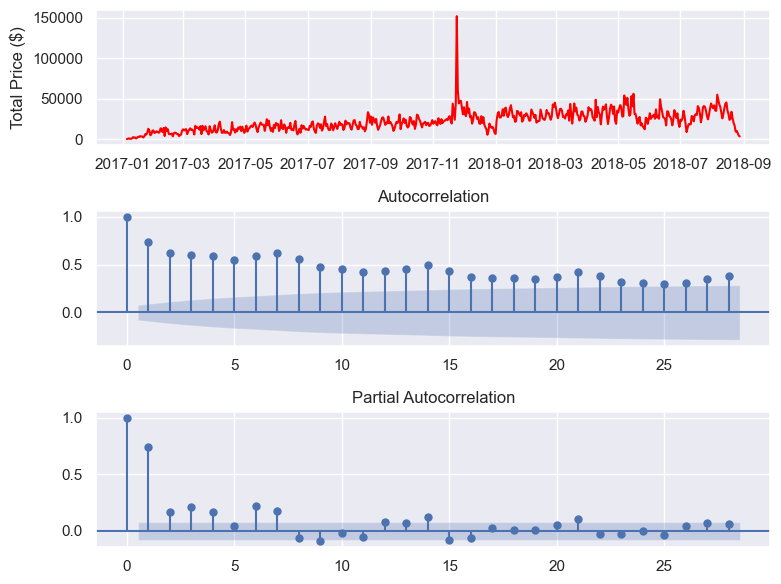

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(8,6))
a1.plot(series, color='red')
a1.set_ylabel('Total Price ($)')
plot_acf(series, ax=a2)
plot_pacf(series, ax=a3)
plt.tight_layout()
plt.show()

Let's formulate the forecasting problem as follows:
1. Create a traininig dataset which includes all daily data except for the last 10 days of August
2. Create a test dataset of the last 10 days

After fitting our model, we can simply forecast for this period and assess the goodness of fit.

In [53]:
#create a train-test split
test_size = 10 #in days
xt_train = series[:-test_size]
xt_test = series[-test_size:]
print(f'Train data shape: {xt_train.shape}')
print(f'Test data shape: {xt_test.shape}')
assert len(xt_train) + len(xt_test) == len(series)

Train data shape: (591,)
Test data shape: (10,)


In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Postestimation:-Example-1---Dynamic-Forecasting

models = {
    'AR1': SARIMAX(xt_train, order= (1, 0, 0 )),
    'AR3': SARIMAX(xt_train, order= (3, 0, 0 )),
    'AR6': SARIMAX(xt_train, order= (6, 0, 0 )),
    'AR7': SARIMAX(xt_train, order= (7, 0, 0 )),
}

model = models['AR1']
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  591
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6199.265
Date:                Sun, 24 Apr 2022   AIC                          12402.530
Time:                        20:18:49   BIC                          12411.293
Sample:                    01-05-2017   HQIC                         12405.943
                         - 08-18-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9394      0.005    176.422      0.000       0.929       0.950
sigma2      7.546e+07   3.77e-12      2e+19      0.000    7.55e+07    7.55e+07
===================================================================================
Ljung-Box (Q):                      243.93   Jarque-Bera (JB):             84905.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.36   Skew:                             2.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

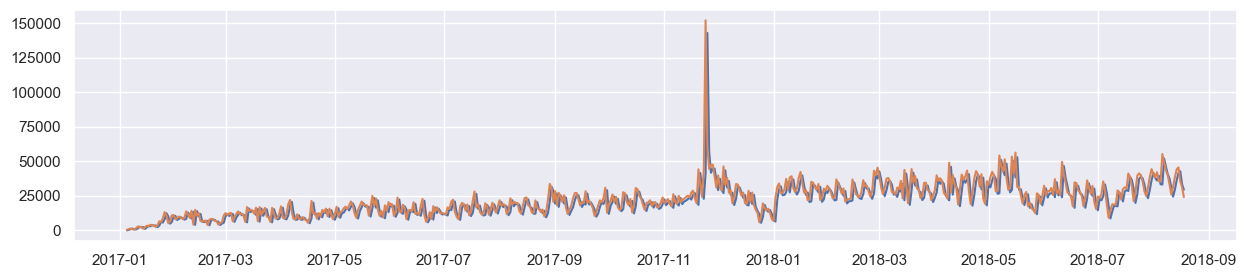

In [55]:
predict = res.get_prediction()
predict_ci = predict.conf_int()
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(predict.predicted_mean)
ax.plot(xt_train)
plt.show()

In [56]:
forecasts = res.get_forecast(steps=len(xt_test)).summary_frame()
forecasts.head()

price,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-08-19,22653.348146,8686.584882,5627.954628,39678.741664
2018-08-20,21280.157172,11918.169661,-2079.026126,44639.340469
2018-08-21,19990.205701,14170.422864,-7783.312759,47763.724160
2018-08-22,18778.447957,15895.010463,-12375.200084,49932.095998
2018-08-23,17640.144026,17274.439367,-16217.134987,51497.423039


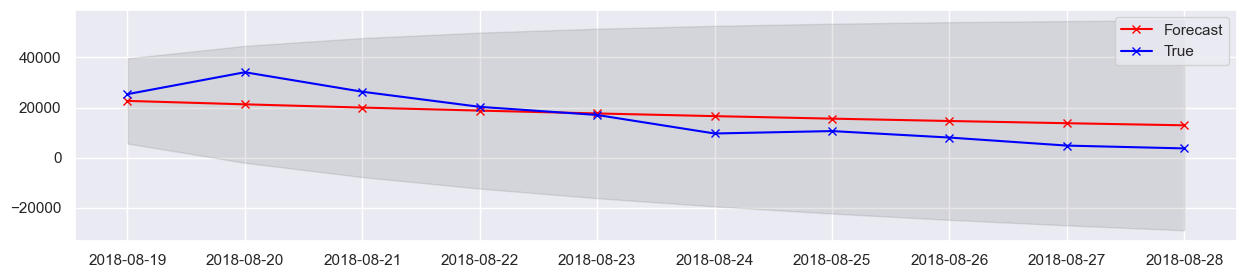

In [57]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(forecasts['mean'], color='red', marker = 'x', label='Forecast')
ax.fill_between(forecasts.index, forecasts['mean_ci_lower'], forecasts['mean_ci_upper'], color='k', alpha=0.1)
ax.plot(xt_test, color='blue', marker = 'x', label = 'True')
plt.legend()
plt.show()

In [58]:
errors = {
    'rmse': np.sqrt(mean_squared_error(xt_test, forecasts['mean'].values)),
    'mae': mean_absolute_error(xt_test, forecasts['mean'].values)
}
errors

{'rmse': 7043.54524789557, 'mae': 6065.271270226066}

From the plot above, we can see:
- The model predicts the proper trend in the next few unseen points quite well
- The true sales figures over the next few days lie well within the prediction interval

# 4. Delivery Time Analysis
***

In this section, we will aim to analyze delivery times for customers and sellers all across Brazil, and then fit a **regressive** model to predict the expected delivery time for an order (based on the locations of the buyer/seller as well as the total weight of the order, category of item in the order).

In [59]:
orderitems_df = load('order_items')
orderitems_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Load main orders dataset

In [60]:
orders_main = load('orders')
print(orders_main.shape)
orders_main = orders_main.loc[orders_main.order_status == 'delivered']
print(orders_main.shape)
orders_main.head()

(99441, 8)
(96478, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Find the delivery times.

In [61]:
orders_main['order_delivered_customer_date'] = pd.to_datetime(orders_main['order_delivered_customer_date'])
orders_main['order_delivered_carrier_date'] = pd.to_datetime(orders_main['order_delivered_carrier_date'])
orders_main['delivery_time'] = orders_main.order_delivered_customer_date - orders_main.order_delivered_carrier_date
orders_main['delivery_time'] = orders_main['delivery_time'].dt.days
print(orders_main.shape)
orders_main = orders_main.loc[~orders_main.delivery_time.isnull()] #Remove null rows
print(orders_main.shape)
orders_main = orders_main.loc[orders_main.delivery_time >= 0] #Remove invalid
print(orders_main.shape)

(96478, 9)
(96469, 9)
(96446, 9)


Let's check the distribution of delivery times.

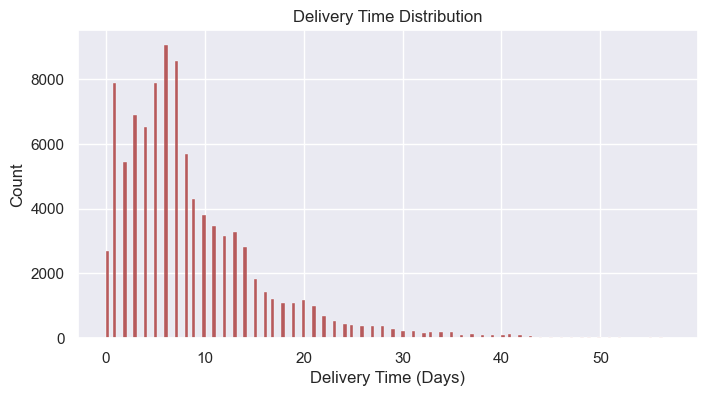

In [62]:
fig, ax = plt.subplots(figsize=(8,4))
delivery_times = orders_main.delivery_time.values
#Remove outliers
delivery_times = delivery_times[np.where(delivery_times < np.percentile(delivery_times, 99.75))]
sns.histplot(delivery_times, color='brown')
ax.set_xlabel('Delivery Time (Days)')
ax.set_title('Delivery Time Distribution')
plt.show()

The **average delivery time** is close to 10 days, but it should be noted that the plot above has been generated by skipping some outliers.

Let's find where customers and sellers are.

In [63]:
customers = load('customers')
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [64]:
sellers = load('sellers')
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [65]:
ord2prod = orderitems_df.merge(prod_translated, on='product_id')
ord_stats = ord2prod.groupby(['order_id', 'product_id', 'seller_id'])[[ 'product_weight_g','price', 'freight_value',]].sum()
ord_stats

,,,product_weight_g,price,freight_value
order_id,product_id,seller_id,,,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,650.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,30000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,3050.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,200.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,3750.0,199.90,18.14
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,10150.0,299.99,43.41
fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,8950.0,350.00,36.53
fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,967.0,99.90,16.95


In [66]:
ordstats_sellers = ord_stats.reset_index().merge(sellers, on='seller_id')
ordstats_sellers

,order_id,product_id,seller_id,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,650.0,58.90,13.29,27277,volta redonda,SP
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,530.0,55.90,9.94,27277,volta redonda,SP
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2275.0,132.90,20.17,27277,volta redonda,SP
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,400.0,58.90,15.16,27277,volta redonda,SP
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,600.0,139.90,16.74,27277,volta redonda,SP
...,...,...,...,...,...,...,...,...,...
100938,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,1000.0,119.90,16.14,80220,curitiba,PR
100939,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,1050.0,199.99,18.14,14402,franca,SP
100940,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,500.0,209.00,16.21,82620,curitiba,PR
100941,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,5660.0,6729.00,193.21,86026,londrina,PR


In [67]:
orders_full = orders_main.merge(customers, on='customer_id').merge(ordstats_sellers, on = 'order_id')
print(orders_full[['order_id', 'customer_id', 'seller_id']].duplicated().any())
print(orders_full[['order_id', 'customer_id', 'seller_id', 'product_id']].duplicated().any()) #UNIQUE
orders_full = orders_full.set_index(['order_id', 'customer_id', 'seller_id', 'product_id'])
orders_full

True
False


,,,,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,500.0,29.99,8.72,9350,maua,SP
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,12.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,400.0,118.70,22.76,31570,belo horizonte,SP
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,420.0,159.90,19.22,14840,guariba,SP
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,9.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,450.0,45.00,27.20,31842,belo horizonte,MG
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,250.0,19.90,8.72,8752,mogi das cruzes,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,7.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1175.0,72.00,13.08,12913,braganca paulista,SP
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,20.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4950.0,174.90,20.10,17602,tupa,SP
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,23.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,13300.0,205.99,65.02,8290,sao paulo,SP


In [68]:
orders_full.reset_index(inplace=True)
orders_full['product_category'] = orders_full.product_id.apply(get_catname)
orders_full.set_index(['order_id', 'customer_id', 'seller_id', 'product_id'], inplace=True)
orders_full

,,,,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,product_category
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,500.0,29.99,8.72,9350,maua,SP,housewares
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,12.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,400.0,118.70,22.76,31570,belo horizonte,SP,perfumery
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,420.0,159.90,19.22,14840,guariba,SP,auto
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,9.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,450.0,45.00,27.20,31842,belo horizonte,MG,pet_shop
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,250.0,19.90,8.72,8752,mogi das cruzes,SP,stationery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,7.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1175.0,72.00,13.08,12913,braganca paulista,SP,health_beauty
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,20.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4950.0,174.90,20.10,17602,tupa,SP,baby
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,23.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,13300.0,205.99,65.02,8290,sao paulo,SP,home_appliances_2


## Delivery Time factors

Let's dive into how the locations of the customers and sellers, as well as product types impact delivery times.

In [69]:
states_gby = orders_full.groupby(['customer_state','seller_state']).median()['delivery_time']
states_gby

customer_state  seller_state
AC              BA              63.0
                DF               7.0
                GO              14.0
                MA              15.0
                MG              15.0
                                ... 
TO              PR              16.0
                RJ              10.0
                RS              10.0
                SC              15.0
                SP              13.0
Name: delivery_time, Length: 410, dtype: float64

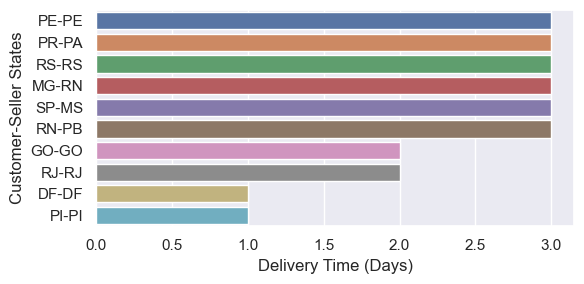

In [70]:
sorted_states_gby = states_gby.sort_values(ascending=False).tail(n=10)
sorted_states_gby = sorted_states_gby.reset_index()
customer_seller_states = [f'{cust}-{sell}' for cust, sell in zip(sorted_states_gby.customer_state, sorted_states_gby.seller_state)]
delivery_times = sorted_states_gby.delivery_time.values
# print(delivery_times)

fig, a1 = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(ax=a1, x=delivery_times, y=customer_seller_states)
a1.set_xlabel('Delivery Time (Days)')
a1.set_ylabel('Customer-Seller States')
plt.tight_layout()
plt.show()

Let's check the longest delivery routes.

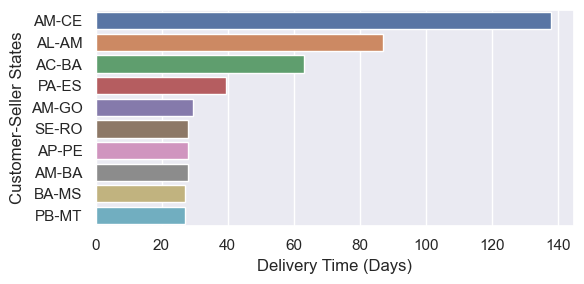

In [71]:
sorted_states_gby = states_gby.sort_values(ascending=False).head(n=10)
sorted_states_gby = sorted_states_gby.reset_index()
customer_seller_states = [f'{cust}-{sell}' for cust, sell in zip(sorted_states_gby.customer_state, sorted_states_gby.seller_state)]
delivery_times = sorted_states_gby.delivery_time.values

fig, a1 = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(ax=a1, x=delivery_times, y=customer_seller_states)
a1.set_xlabel('Delivery Time (Days)')
a1.set_ylabel('Customer-Seller States')
plt.tight_layout()
plt.show()

Which products take longest to ship?

In [72]:
cat_dtime_gby = orders_full.groupby(['product_category',]).median()['delivery_time']
cat_dtime_gby

product_category
agro_industry_and_commerce    6.5
air_conditioning              6.0
art                           6.0
arts_and_craftmanship         2.0
audio                         7.0
                             ... 
stationery                    7.0
tablets_printing_image        7.0
telephony                     7.0
toys                          7.0
watches_gifts                 7.0
Name: delivery_time, Length: 71, dtype: float64

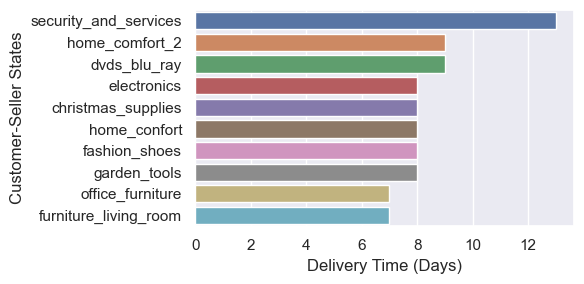

In [73]:
sorted_cat_gby = cat_dtime_gby.sort_values(ascending=False).head(n=10)
sorted_cat_gby = sorted_cat_gby.reset_index()
delivery_times = sorted_cat_gby.delivery_time.values
categories = sorted_cat_gby.product_category.values

fig, a1 = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(ax=a1, x=delivery_times, y=categories)
a1.set_xlabel('Delivery Time (Days)')
a1.set_ylabel('Customer-Seller States')
plt.tight_layout()
plt.show()

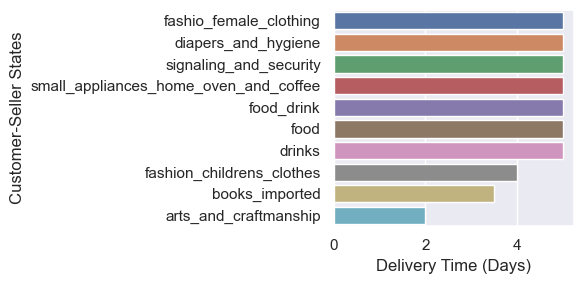

In [74]:
sorted_cat_gby = cat_dtime_gby.sort_values(ascending=False).tail(n=10)
sorted_cat_gby = sorted_cat_gby.reset_index()
delivery_times = sorted_cat_gby.delivery_time.values
categories = sorted_cat_gby.product_category.values

fig, a1 = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(ax=a1, x=delivery_times, y=categories)
a1.set_xlabel('Delivery Time (Days)')
a1.set_ylabel('Customer-Seller States')
plt.tight_layout()
plt.show()

We should also inspect if there seems to be some trend between weight of an order (or freight cost) and the delivery time.

We can reasonably expect a positive correlation (given basic logistics).

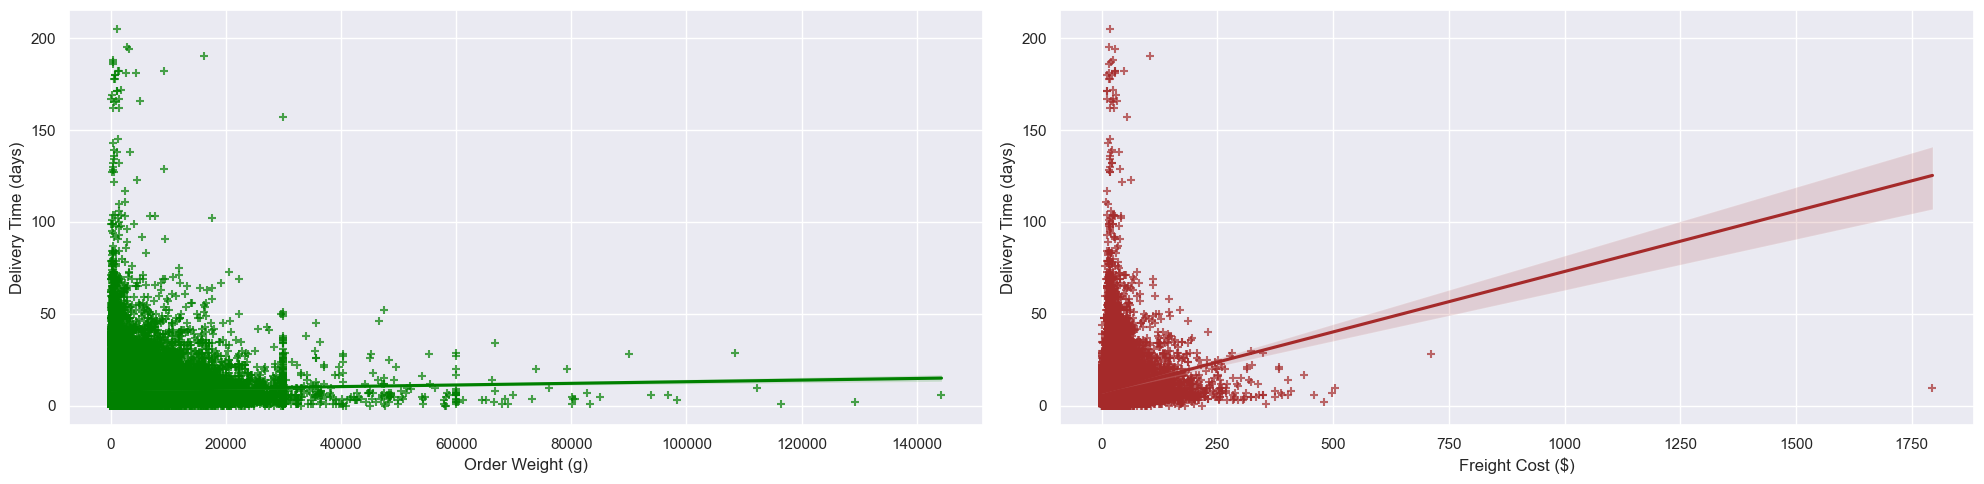

In [75]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(20, 5))
#Subset
freight_values = orders_full.freight_value.values
weights = orders_full.product_weight_g.values
delivery_times = orders_full.delivery_time.values

sns.regplot(ax=a1, x=weights, y=delivery_times, color='green', marker='+', scatter_kws={'alpha':0.7})
sns.regplot(ax=a2, x=freight_values, y=delivery_times, color='brown', marker='+', scatter_kws={'alpha':0.7})
a1.set_xlabel('Order Weight (g)')
a2.set_xlabel('Freight Cost ($)')

a1.set_ylabel('Delivery Time (days)')
a2.set_ylabel('Delivery Time (days)')
plt.tight_layout()
plt.show()

In [76]:
orders_full['same_state'] = orders_full['customer_state'] == orders_full['seller_state']
orders_full.same_state.values

array([ True, False, False, ..., False, False, False])

Is the delivery time lower when customer and seller are in the same state?


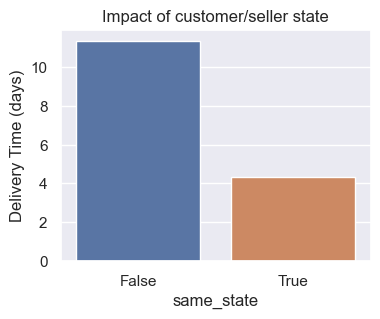

In [77]:
fig, ax = plt.subplots(figsize=(4,3))
same_state_delivery_time = orders_full.groupby('same_state').mean()['delivery_time']
sns.barplot(x=same_state_delivery_time.index, y=same_state_delivery_time.values, ax=ax)
ax.set_ylabel('Delivery Time (days)')
ax.set_title('Impact of customer/seller state')
plt.show()

Clearly, when customers and sellers are located in the same state, delivery times are significantly lower.

## Predicting Delivery Time

In [78]:
features = ['product_weight_g','freight_value' , 'customer_state', 'seller_state', 'product_category', 'same_state']
data = orders_full[features + ['delivery_time']]
X = data[features]
y = data['delivery_time']
X

,,,,product_weight_g,freight_value,customer_state,seller_state,product_category,same_state
order_id,customer_id,seller_id,product_id,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,500.0,8.72,SP,SP,housewares,True
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,400.0,22.76,BA,SP,perfumery,False
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,420.0,19.22,GO,SP,auto,False
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,450.0,27.20,RN,MG,pet_shop,False
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,250.0,8.72,SP,SP,stationery,True
...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,1175.0,13.08,SP,SP,health_beauty,True
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,4950.0,20.10,SP,SP,baby,True
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,13300.0,65.02,BA,SP,home_appliances_2,False


We apply **One-Hot Encoding** to deal with the categorical variables denoting the customer and seller locations.

In [79]:
X = pd.get_dummies(X)
X

,,,,product_weight_g,freight_value,same_state,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,...,product_category_security_and_services,product_category_signaling_and_security,product_category_small_appliances,product_category_small_appliances_home_oven_and_coffee,product_category_sports_leisure,product_category_stationery,product_category_tablets_printing_image,product_category_telephony,product_category_toys,product_category_watches_gifts
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,500.0,8.72,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,400.0,22.76,False,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,420.0,19.22,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,450.0,27.20,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,250.0,8.72,True,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,1175.0,13.08,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,4950.0,20.10,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,13300.0,65.02,False,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
X = X.values
X[:, 2:] = X[:, 2:].astype(int)
y = y.values
print(f'Input data ( Shape: {X.shape}): \n {X}')
print(f'Targets ( Shape: {y.shape}): \n {y}')

Input data ( Shape: (98724, 123)): 
 [[500.0 8.72 1 ... 0 0 0]
 [400.0 22.76 0 ... 0 0 0]
 [420.0 19.22 0 ... 0 0 0]
 ...
 [13300.0 65.02 0 ... 0 0 0]
 [13100.0 81.18 0 ... 0 0 0]
 [150.0 18.36 0 ... 0 0 0]]
Targets ( Shape: (98724,)): 
 [ 6. 12.  9. ... 23. 13.  6.]


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'X_train shape: {X_train.shape} \t X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}')

X_train shape: (93787, 123) 	 X_test shape: (4937, 123)
y_train shape: (93787,) 	 y_test shape: (4937,)


### XGBoost Regressor

We will use another **ensemble** learning method as our predictive model in this section as well. **XGBoost** is extremely popular in the field and are widely used ([Reference](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html#:~:text=XGBoost%20has%20become%20a%20widely,production%20on%20large%2Dscale%20problems.)) in a variety of domains on the regular. Their ensembling nature helps reduce overfitting, and they are also quite suitable in the case of **imbalanced data** as compared to the RandomForest Regressor model from earlier.([Reference Article](https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30)).

In [82]:
import xgboost
from xgboost import XGBRegressor

In [83]:
'''
Reference: 
- #https://machinelearningmastery.com/xgboost-for-regression/
- https://www.geeksforgeeks.org/xgboost-for-regression/
'''
model = XGBRegressor(n_estimators=10, max_depth=10, eta=0.3)
model.fit(X_train, y_train)

yhat_train = np.round(model.predict(X_train))
yhat_test = np.round(model.predict(X_test))

#Errors
errors = {}
errors['train_rmse'] = np.sqrt(mean_squared_error(y_train, yhat_train))
errors['test_rmse'] = np.sqrt(mean_squared_error(y_test, yhat_test))
errors['train_mae'] = mean_absolute_error(y_train, yhat_train)
errors['test_mae'] = mean_absolute_error(y_test, yhat_test)
errors['train_r2'] = r2_score(y_train, yhat_train)
errors['test_r2'] = r2_score(y_test, yhat_test)

errors

{'train_rmse': 7.183300490948043,
 'test_rmse': 7.101452378645209,
 'train_mae': 4.206307910477998,
 'test_mae': 4.300182296941462,
 'train_r2': 0.32781352872693903,
 'test_r2': 0.2324295262220285}

In [84]:
np.std(y_test)

8.105653766950198

Our regressor's **Test RMSE** is marginally better (lower) than the **Standard Deviation** in the test dataset, so our model performs better than a random preictor.

# 5. Conclusions/Future Extensions

In this analysis, we have extensively analyzed some key aspects of in-depth sales data for a dynamic marketplace. More concretely, we have:
- Analyzed popular products, delivery times and daily sales data
- Trained a predictive model capable of estimating freight costs associated with an order
- Built an undupervised ML model capable of segmenting orders based on their prices and total weights
- Fitted and evaluated a fairly effective forecasting model capable of predicting daily sales
- Trained a predictive model capable of predicting delivery times based on order composition and seller-customer distance

Future avenues of research may involve:
- Machine Translation to translate customer reviews from Portuguese to English, and consequence Sentiment Analysis
- Build customer segmentation models (unsupervised models would be quite nifty here)
- Build better, and even more robust forecasting models